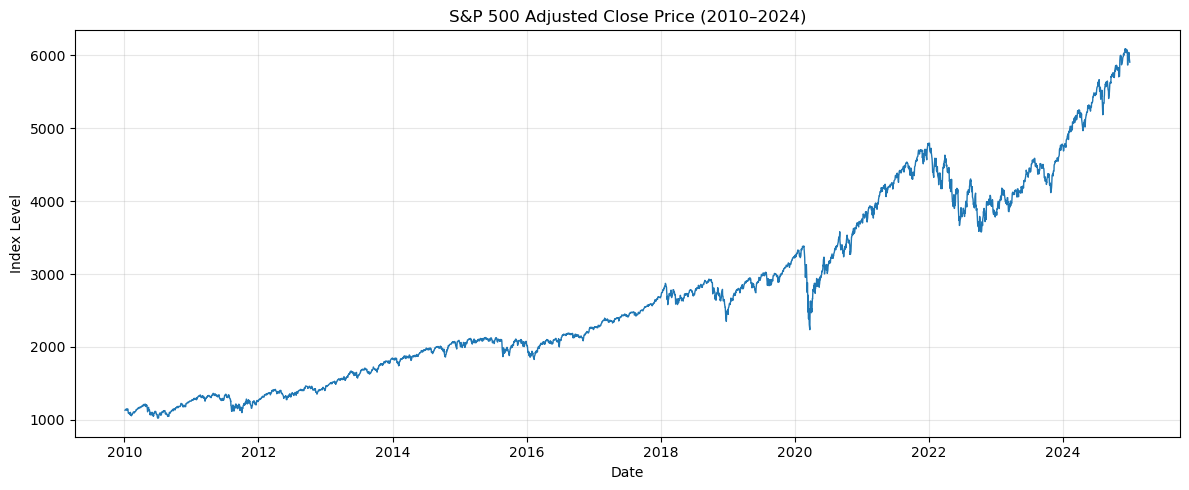

In [1]:
# --- 1. Imports and data download ---

!pip install yfinance arch

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import jarque_bera
import statsmodels.api as sm

from arch import arch_model

plt.rcParams["figure.figsize"] = (10, 5)

# --- Download S&P 500 index (GSPC) ---

sp500 = yf.download(
    "^GSPC",
    start="2010-01-01",
    end="2024-12-31",
    progress=False,
    auto_adjust=False   # keep "Adj Close" separate
)

# Keep adjusted close and clean index
sp500 = sp500[["Adj Close"]].rename(columns={"Adj Close": "AdjClose"})
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.sort_index()

# 3. Plot price level
plt.figure(figsize=(12, 5))
plt.plot(sp500.index, sp500["AdjClose"], linewidth=1)

plt.title("S&P 500 Adjusted Close Price (2010–2024)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Descriptive statistics for daily S&P 500 log-returns (%, 2010–2024):
count    3772.000000
mean        0.043777
std         1.088971
min       -12.765220
1%         -3.184854
5%         -1.662504
25%        -0.380964
50%         0.068057
75%         0.567455
95%         1.542046
99%         2.629593
max         8.968323
Name: Ret, dtype: float64

Skewness: -0.726
Excess kurtosis: 13.214


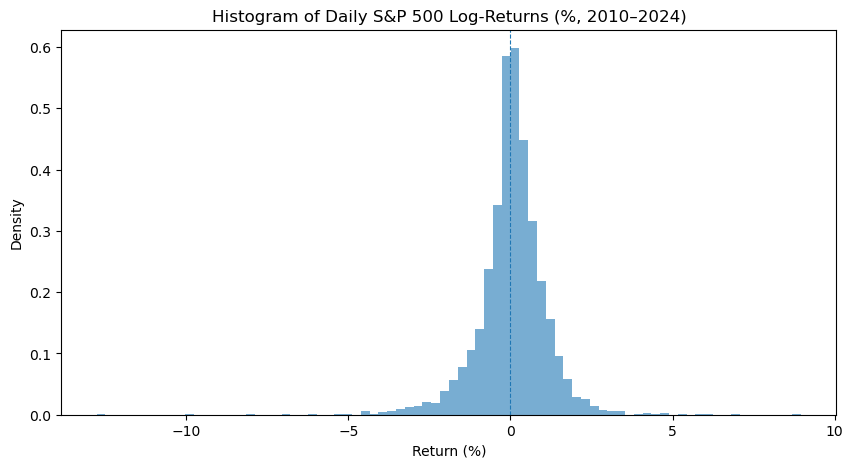

Jarque–Bera: stat = 27696.630, p-value = 0.00000


In [2]:
# --- 2. Compute daily log-returns and descriptive statistics ---

# 100 * log-returns (percentage units)
sp500["Ret"] = 100 * np.log(sp500["AdjClose"] / sp500["AdjClose"].shift(1))
sp500 = sp500.dropna()
returns = sp500["Ret"].copy()

# Descriptive statistics
desc = returns.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("Descriptive statistics for daily S&P 500 log-returns (%, 2010–2024):")
print(desc)
print("\nSkewness:", f"{returns.skew():.3f}")
print("Excess kurtosis:", f"{returns.kurtosis():.3f}")

# Histogram of returns
plt.hist(returns, bins=80, density=True, alpha=0.6)
plt.title("Histogram of Daily S&P 500 Log-Returns (%, 2010–2024)")
plt.xlabel("Return (%)")
plt.ylabel("Density")
plt.axvline(0, linestyle="--", linewidth=0.8)
plt.show()

# Jarque–Bera normality test
jb_stat, jb_p = jarque_bera(returns)
print(f"Jarque–Bera: stat = {jb_stat:.3f}, p-value = {jb_p:.5f}")




ADF statistic: -13.343763874845276
p-value: 5.84984517324987e-25
Critical value (1%%): -3.432097339894967
Critical value (5%%): -2.862312078352202
Critical value (10%%): -2.567180988001804


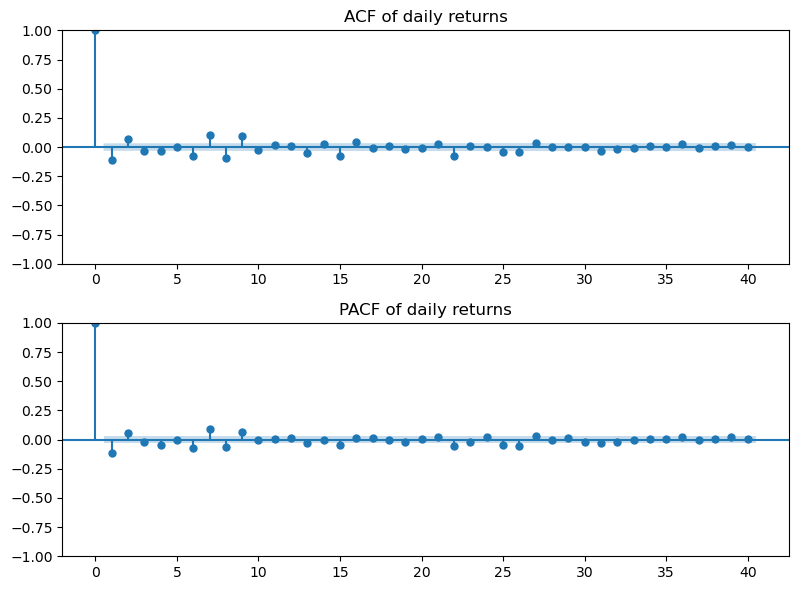

<Figure size 800x300 with 0 Axes>

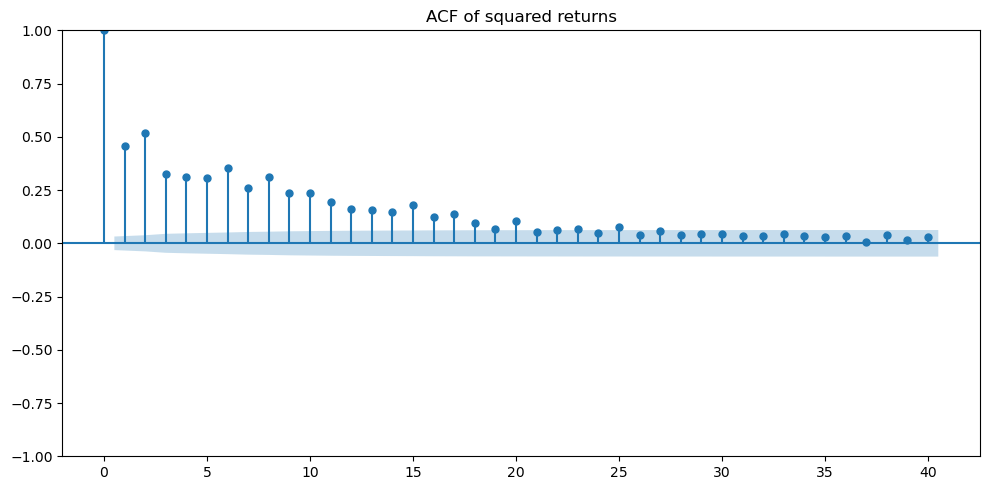


ARCH LM statistic: 1257.3769830805645
p-value: 6.030532412653931e-264


In [3]:
# --- 3. Stationarity and serial correlation tests ---

# 3.1 ADF unit root test on returns
adf_stat, adf_p, _, _, crit_vals, _ = adfuller(returns)
print("\nADF statistic:", adf_stat)
print("p-value:", adf_p)
for k, v in crit_vals.items():
    print(f"Critical value ({k}%): {v}")

# 3.2 ACF and PACF of returns
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(returns, lags=40, ax=axes[0])
axes[0].set_title("ACF of daily returns")

plot_pacf(returns, lags=40, ax=axes[1], method="ywmle")
axes[1].set_title("PACF of daily returns")
plt.tight_layout()
plt.savefig("ACF.png", dpi=300)
plt.show()

# 3.3 ACF of squared returns to detect ARCH effects
plt.figure(figsize=(8, 3))
plot_acf(returns**2, lags=40)
plt.title("ACF of squared returns")
plt.tight_layout()
plt.tight_layout()
plt.show()

# 3.4 Formal ARCH LM test using AR(1) residuals
y = returns
X = add_constant(y.shift(1).dropna())
y_aligned = y.loc[X.index]

ar1_model = OLS(y_aligned, X).fit()
resid = ar1_model.resid

arch_stat, arch_p, _, _ = het_arch(resid, nlags=10)
print("\nARCH LM statistic:", arch_stat)
print("p-value:", arch_p)


In [4]:
# --- 4. FOMC event dummies: all meetings vs. rate-change meetings ---

fomc_all_dates = [
    # 2010
    "2010-01-27","2010-03-16","2010-04-28","2010-05-09","2010-06-23",
    "2010-08-10","2010-09-21","2010-11-03","2010-12-14",
    # 2011
    "2011-01-26","2011-03-15","2011-04-27","2011-06-22","2011-08-09",
    "2011-09-21","2011-11-02","2011-12-13",
    # 2012
    "2012-01-25","2012-03-13","2012-04-25","2012-06-20","2012-08-01",
    "2012-09-13","2012-10-24","2012-12-12",
    # 2013
    "2013-01-30","2013-03-20","2013-05-01","2013-06-19","2013-07-31",
    "2013-09-18","2013-10-30","2013-12-18",
    # 2014
    "2014-01-29","2014-03-19","2014-04-30","2014-06-18","2014-07-30",
    "2014-09-17","2014-10-29","2014-12-17",
    # 2015
    "2015-01-28","2015-03-18","2015-04-29","2015-06-17","2015-07-29",
    "2015-09-17","2015-10-28","2015-12-16",
    # 2016
    "2016-01-27","2016-03-16","2016-04-27","2016-06-15","2016-07-27",
    "2016-09-21","2016-11-02","2016-12-14",
    # 2017
    "2017-02-01","2017-03-15","2017-05-03","2017-06-14","2017-07-26",
    "2017-09-20","2017-11-01","2017-12-13",
    # 2018
    "2018-01-31","2018-03-21","2018-05-02","2018-06-13","2018-08-01",
    "2018-09-26","2018-11-08","2018-12-19",
    # 2019
    "2019-01-30","2019-03-20","2019-05-01","2019-06-19","2019-07-31",
    "2019-09-18","2019-10-30","2019-12-11",
    # 2020 (incl. emergencies)
    "2020-01-29","2020-03-03","2020-03-15","2020-04-29","2020-06-10",
    "2020-07-29","2020-09-16","2020-11-05","2020-12-16",
    # 2021
    "2021-01-27","2021-03-17","2021-04-28","2021-06-16","2021-07-28",
    "2021-09-22","2021-11-03","2021-12-15",
    # 2022
    "2022-01-26","2022-03-16","2022-05-04","2022-06-15","2022-07-27",
    "2022-09-21","2022-11-02","2022-12-14",
    # 2023
    "2023-02-01","2023-03-22","2023-05-03","2023-06-14","2023-07-26",
    "2023-11-01","2023-12-13",
    # 2024
    "2024-01-31","2024-03-20","2024-05-01","2024-06-12","2024-07-31",
    "2024-09-18","2024-11-07","2024-12-18"
]

# Rate-change meetings subset
fomc_rate_dates = [
    "2015-12-16",
    "2016-12-14",
    "2017-03-15","2017-06-14","2017-12-13",
    "2018-03-21","2018-06-13","2018-09-26","2018-12-19",
    "2019-07-31","2019-09-18","2019-10-30",
    "2020-03-03","2020-03-15",
    "2022-03-16","2022-05-04","2022-06-15","2022-07-27",
    "2022-09-21","2022-11-02","2022-12-14",
    "2023-02-01","2023-03-22","2023-05-03","2023-07-26",
    "2024-09-18","2024-11-07","2024-12-18"
]

fomc_all_index = pd.to_datetime(fomc_all_dates)
fomc_rate_index = pd.to_datetime(fomc_rate_dates)

sp500["FOMC_all"] = sp500.index.isin(fomc_all_index).astype(int)
sp500["FOMC_rate"] = sp500.index.isin(fomc_rate_index).astype(int)

print("Total days:", len(sp500))
print("FOMC_all days:", sp500["FOMC_all"].sum())
print("FOMC_rate days:", sp500["FOMC_rate"].sum())

# Quick descriptive comparison of returns by FOMC status
print("\nReturns by FOMC_all:")
print(sp500.groupby("FOMC_all")["Ret"].agg(["mean", "std", "median"]))

print("\nReturns by FOMC_rate:")
print(sp500.groupby("FOMC_rate")["Ret"].agg(["mean", "std", "median"]))


Total days: 3772
FOMC_all days: 119
FOMC_rate days: 27

Returns by FOMC_all:
              mean       std    median
FOMC_all                              
0         0.041016  1.085714  0.069645
1         0.128529  1.186436  0.028262

Returns by FOMC_rate:
               mean       std    median
FOMC_rate                              
0          0.045241  1.085283  0.069308
1         -0.159350  1.530686 -0.184569


In [5]:
# --- 5. Baseline AR(1)–EGARCH(1,1) with Student-t errors ---

egarch_model = arch_model(
    sp500["Ret"],
    mean="AR",
    lags=1,
    vol="EGARCH",
    p=1,
    o=1,          # leverage term
    q=1,
    dist="StudentsT"
)

egarch_res = egarch_model.fit(update_freq=10, disp="off")
print(egarch_res.summary())


                             AR - EGARCH Model Results                              
Dep. Variable:                          Ret   R-squared:                       0.006
Mean Model:                              AR   Adj. R-squared:                  0.006
Vol Model:                           EGARCH   Log-Likelihood:               -4648.35
Distribution:      Standardized Student's t   AIC:                           9310.71
Method:                  Maximum Likelihood   BIC:                           9354.35
                                              No. Observations:                 3771
Date:                      Tue, Dec 02 2025   Df Residuals:                     3769
Time:                              18:15:17   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [6]:
# --- 5. Baseline AR(1)–EGARCH(1,1) with Student-t errors ---

egarch_model = arch_model(
    sp500["Ret"],
    mean="AR",
    lags=1,
    vol="EGARCH",
    p=1,
    o=1,          # leverage term
    q=1,
    dist="StudentsT"
)

egarch_res = egarch_model.fit(update_freq=10, disp="off")
print(egarch_res.summary())


                             AR - EGARCH Model Results                              
Dep. Variable:                          Ret   R-squared:                       0.006
Mean Model:                              AR   Adj. R-squared:                  0.006
Vol Model:                           EGARCH   Log-Likelihood:               -4648.35
Distribution:      Standardized Student's t   AIC:                           9310.71
Method:                  Maximum Likelihood   BIC:                           9354.35
                                              No. Observations:                 3771
Date:                      Tue, Dec 02 2025   Df Residuals:                     3769
Time:                              18:15:17   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

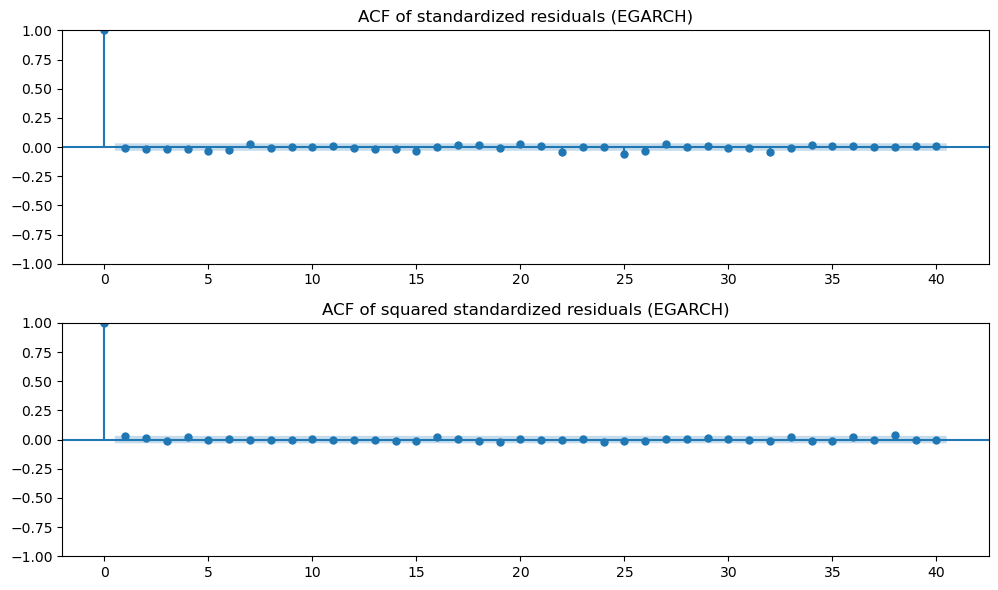

Ljung–Box on standardized residuals:
      lb_stat  lb_pvalue
10  11.813611   0.297725
20  23.961109   0.244095

Ljung–Box on squared standardized residuals:
      lb_stat  lb_pvalue
10   6.307134   0.788833
20  11.826937   0.921904

Jarque–Bera on standardized residuals: stat = 2740.952, p = 0.00000


In [20]:
# --- EGARCH residual diagnostics (serial correlation & remaining ARCH) ---

std_resid = egarch_res.std_resid.dropna()
std_resid_sq = std_resid**2

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(std_resid, lags=40, ax=axes[0])
axes[0].set_title("ACF of standardized residuals (EGARCH)")
plot_acf(std_resid_sq, lags=40, ax=axes[1])
axes[1].set_title("ACF of squared standardized residuals (EGARCH)")
plt.tight_layout()
plt.savefig("ACF and PACF of squared standardized residuals.png", dpi=300)
plt.show()

print("Ljung–Box on standardized residuals:")
print(acorr_ljungbox(std_resid, lags=[10, 20], return_df=True))

print("\nLjung–Box on squared standardized residuals:")
print(acorr_ljungbox(std_resid_sq, lags=[10, 20], return_df=True))

jb_stat, jb_p = jarque_bera(std_resid)
print(f"\nJarque–Bera on standardized residuals: stat = {jb_stat:.3f}, p = {jb_p:.5f}")


In [8]:
# --- 6. ARCH-X style variance regression: log(squared returns) ---

# Log squared returns as variance proxy
log_r2 = np.log(sp500["Ret"]**2).replace(-np.inf, np.nan)

df_archx = pd.DataFrame({
    "log_r2": log_r2,
    "log_r2_lag1": log_r2.shift(1),
    "FOMC_all": sp500["FOMC_all"],
    "FOMC_rate": sp500["FOMC_rate"]
}).dropna()

y_var = df_archx["log_r2"]
X_var = sm.add_constant(df_archx[["log_r2_lag1", "FOMC_all", "FOMC_rate"]])

archx_ols = sm.OLS(y_var, X_var).fit(
    cov_type="HAC",
    cov_kwds={"maxlags": 5}
)

print(archx_ols.summary())


                            OLS Regression Results                            
Dep. Variable:                 log_r2   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     13.21
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.41e-08
Time:                        18:15:18   Log-Likelihood:                -8917.0
No. Observations:                3769   AIC:                         1.784e+04
Df Residuals:                    3765   BIC:                         1.787e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.6687      0.067    -24.793      

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# --- 7. Robustness: ARX model for absolute returns ---

df_abs = pd.DataFrame({
    "abs_ret": np.abs(sp500["Ret"]),
    "lag_abs": np.abs(sp500["Ret"].shift(1)),
    "FOMC_all": sp500["FOMC_all"],
    "FOMC_rate": sp500["FOMC_rate"]
}).dropna()

y_abs = df_abs["abs_ret"]
X_abs = sm.add_constant(df_abs[["lag_abs", "FOMC_all", "FOMC_rate"]])

arx_abs = sm.OLS(y_abs, X_abs).fit(
    cov_type="HAC",
    cov_kwds={"maxlags": 5}
)

print(arx_abs.summary())


                            OLS Regression Results                            
Dep. Variable:                abs_ret   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     9.289
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           4.06e-06
Time:                        18:15:18   Log-Likelihood:                -4374.8
No. Observations:                3771   AIC:                             8758.
Df Residuals:                    3767   BIC:                             8782.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4851      0.048     10.016      0.0